### Team details {-}
Add the names of all team members and a short description of each member's contributions.   
* TEAM MEMBER 1 = Perry van Asseldonk 
* TEAM MEMBER 2 = Irfan Ahmed
* TEAM MEMBER 3 = Angela Cha
* TEAM MEMBER 4 = Merel Ypinga
* TEAM MEMBER 5 = Yme van der Linden

## 1. Implementing Bayesian Optimization (60 points) {-}
* Implement Bayesian optimization using the code above and use it to optimize the hyperparameters stated below for each of the two datasets.
    - Use the hyperparameters and ranges are defined above. Make sure to sample from a log scale (`numpy.logspace`) whenever the hyperparameters should be varied on a log scale. 
    - The evaluation measure for classification should be misclassification error (1 - Accuracy), evaluated using 3-fold cross-validation
    - The evaluation measure for regression should be mean squared error, also evaluated using 3-fold cross-validation
* Initialize the surrogate model with 10 randomly sampled configurations and visualize the surrogate model.
    - Hint: Use a 2D slice of each hyperparameter (e.g. $C$=4 and $\gamma$=0.1) to show both the predicted values and the uncertainty.
    - For simplicity, you can build a separate surrogate model for each algorithm and each dataset (4 models in total) 
* Visualize the resulting acquisition function, either as 2D slices (or, more difficult, as a 3D surface)
* Visualize 3 more iterations, each time visualizing the surrogate model and acquisition function
* Run the Bayesian optimization for at least 30 iterations, report the optimal configuration and show the final surrogate model (2D slices or 3D surface).
* Interpret and explain the results. Does Bayesian optimization efficiently find good configurations? Do you notice any
differences between the different models and the different datasets. Explain the results as well as you can.

Since the procedure is very similar for the four models (Support vector machine, GradBoost, GradBoostRegressor and Elasticnet), we only provide one complete run through of our code here. For the other three models, the procedure is almost the same, the only change being the actual model used and the different hyperparameter setups. Therefore, for the other models, we only provide the chosen hyperparameters, the model initialization and the results that were obtained, alongside the discussion. The model that we will completely elaborate is the **support vector machine**. Since we had to re-use our code for four different models, we designed our code to be easily re-usable. This means that there are somewhat large callstacks and functions involved, all with designed so that our code would be "plug and play" for the other models. 

In [10]:
#Handle necessary imports
import numpy as np
from matplotlib import pyplot as plt
import openml as oml
from sklearn.svm import SVC
from sklearn.model_selection import  cross_validate
from sklearn.ensemble import RandomForestRegressor 
import pickle
from scipy.stats import norm
np.random.seed(47)

In [5]:
#Code that was provided
class ProbabilisticRandomForestRegressor(RandomForestRegressor):
    """
    A Random Forest regressor that can also returns the standard deviations for all predictions
    """
    def predict(self, X, return_std=True):
        preds = []
        for pred in self.estimators_:
            preds.append(pred.predict(X))
        if return_std:
            return np.mean(preds, axis=0), np.std(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

def EI(surrogate, X: np.ndarray, curr_best=0.0, balance=0.0, **kwargs):
    """Computes the Expected Improvement
    surrogate, The surrogate model
    X: np.ndarray(N, D), The input points where the acquisition function
    should be evaluated. N configurations with D hyperparameters
    curr_best, The current best performance
    balance, Decrease to focus more on exploration, increase to focus on exploitation (Returns
    -------
    np.ndarray(N,1), Expected Improvement of X
    """
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    m, s = surrogate.predict(X) # mean, stdev
    z = (curr_best - m - balance) / s
    f = (curr_best - m - balance) * norm.cdf(z) + s * norm.pdf(z)
    if np.any(s == 0.0): # uncertainty should never be exactly 0.0
        f[s == 0.0] = 0.0
    return f

In [6]:
#Load robot navigation data to be used in the Support vector Machine
def load_nav_data():
    robotnav = oml.datasets.get_dataset(1497)
    X_nav, y_nav, cats, attrs = robotnav.get_data(dataset_format='array',
    target=robotnav.default_target_attribute)
    return X_nav, y_nav

NOTE:

We Tried to visualize the Surrogate and the Acquisition function both as 3D plots and as heatmaps. 
However, the heatmap was very messy and not too informative as there is a grid of 25 by 25 hyperparameters, 
(so 625 values in a heatmap, it gets really big and messy). Also most of the values were very close to eachother. 
The 3D plots of matplotlib don't really support logarithmic axes yet, this seems to be a known issue:

- https://stackoverflow.com/questions/3909794/plotting-mplot3d-axes3d-xyz-surface-plot-with-log-scale
- https://github.com/matplotlib/matplotlib/issues/209

Therefore we decided to stick with 2D slices, even though they are a less 'complete' way to do the hyperparameter search. 
We hope this does not affect our grade.
        

In [7]:
#Load data, define parameter ranges, random parameter selections and the required slices. NOTE: For the fixed-gamma slice,
#We fixed gamma at 1/24, because the default in sklearn is 1/n_features, and the robot navigation data has 24 features. 
X_nav, y_nav = load_nav_data()
c_points = np.logspace(-12,12, 25)                                      #Create a range of parameter c, on a logarithmic scale, from 1e-12 to 1e12
gamma_points = np.logspace(-12, 12, 25)                                 #Create a range of parameter gamma, on a logarithmic scale, from 1e-12 to 1e12
sample_c = np.random.choice(c_points, 10 , replace=False)               #Sample 10 random points out of the parameter c range
sample_g = np.random.choice(gamma_points, 10, replace=False)            #Sample 10 random points out of the parameter gamma range

random_hyperparams = np.array(list(zip(sample_c, sample_g)))            #Zip together sample_c and sample_g, cast it to the right data structure (np.array)
c_points_gamma_fixed = np.array([(c, 1/24) for c in c_points])          #Create a np.array where c varies and gamma is fixed
gamma_points_c_fixed = np.array([(1, gamma) for gamma in gamma_points]) #Create a np.array where gamma varies and c is fixed

In [8]:
def surrogate_model_fitter(random_params, scoring_metric):
    """Function to fit the surrogate model.
     random_params: First iteration list of random params,
     later a list of random params + optimal configurations.
     scoring_metric: scoring metric to evaluate
     returns list of raw scores
     (So three scores per evaluation, one for each fold)"""
    score_list = []
    for param1, param2 in random_params:
        svc = SVC(C=param1, kernel='rbf', gamma= param2)
        score = cross_validate(svc, X_nav, y_nav, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list


def calculate_rf_input(score_list_model, classification=True):
    """Function that converts the raw score_list from
    surrogate_model_fitter into a workable value to input into the
    random forest, or later the Gaussian process. If classification is true,
    it calculates 1- the mean test accuracy (mean of three folds cross-validation).
    if false, it calculates the mean_squared error (To be used in regression dataset)"""
    if classification:
        rf_input = np.array([1 - np.mean(i['test_accuracy']) for i in score_list_model]) #Calculate the means out of the returned accuracy from the standard svm
    else:
        rf_input = np.array([abs(np.mean(i['neg_mean_squared_error'])) for i in score_list_model])
    return rf_input


def random_forest_fitter(score_to_fit, random_params, fixed_slice):
    """Fit the random forest, using the scores outputted by the calculate_rf_input as Y,
    and the random_param list (or later random_param + optimal setup) list as X
    We then use it on some slice to generate new predicted values in the surrogate model.
    We also compute and return the standard deviation (Sigma) for plotting and the fitted model (rf)
    for later use"""
    rf = ProbabilisticRandomForestRegressor(n_estimators=100)
    rf.fit(random_params, score_to_fit)
    Y_pred, sigma = rf.predict(fixed_slice, return_std=True)
    return Y_pred, sigma, rf


def calculate_ei(rf_param, fixed_slice):
    """Calculate expected improvement"""
    return EI(rf_param, fixed_slice)


def surr_acq_plotter(param_x_axis, y_pred_param, sigma_param, ei_score, x_axis_text):
    """Plot the surrogate function and the acquisition function"""
    plt.subplot(2,1,1)
    plt.ylabel('Surrogate model error')
    plt.xscale('log')
    plt.plot(param_x_axis, y_pred_param, 'r.' , markersize=10, label=u'Observations')
    plt.plot(param_x_axis, y_pred_param, label=u'Prediction')
    plt.fill_between(param_x_axis.ravel(),y_pred_param-2*sigma_param,y_pred_param+2*sigma_param,alpha=0.1,label='Uncertainty')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplot(2,1,2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('{}'.format(x_axis_text))
    plt.ylabel('Expected Improvement')
    plt.plot(param_x_axis, ei_score)
    plt.show()

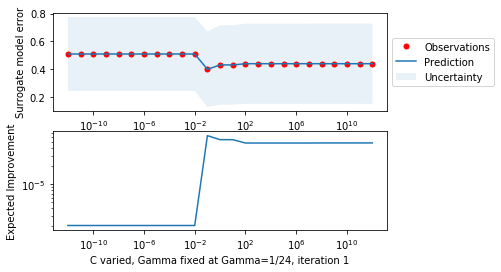

q1 callstack succesfully finished for C varied, Gamma fixed at Gamma=1/24, iteration 1


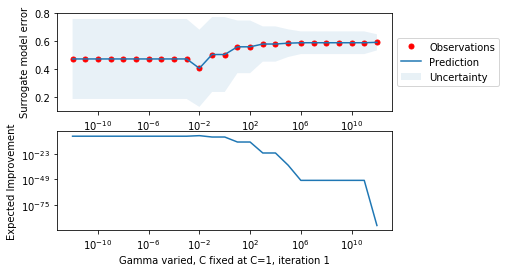

q1 callstack succesfully finished for Gamma varied, C fixed at C=1, iteration 1


In [11]:
#Callstack for the first iteration, bringing all the functions defined above together.
#For detailed overviews of the function calls please refer to the docstrings where the functions
#Are defined.
def q1_callstack( random_param: np.array, scoring_metric: str,  
                 fixed_slice: np.array, param_x_axis:str, x_axis_text: str, classification = True):
    score = surrogate_model_fitter(random_hyperparams, scoring_metric)      #Fit the surrogate model on random hyperparams, return its score
    rf_score = calculate_rf_input(score, classification)                    #Calculate the randomforest inputs 
    y, sig, rf = random_forest_fitter(rf_score, random_param, fixed_slice)  #Fit the random forest on the random parameters, make it predict for the given slice 
    ei_score = calculate_ei(rf, fixed_slice)                                #Calculate the expected improvement on this slice
    surr_acq_plotter(param_x_axis, y, sig, ei_score, x_axis_text)           #Plot the surrogate/acquisition function
    print("q1 callstack succesfully finished for {}".format(x_axis_text))   #Print statement for some feedback 
    return ei_score

#Generate results of the first sub-question; We define two slices, one where C varies and gamma is fixed,
#And one where Gamma is varied and C is fixed. 
ei_score_cvaried_gamma_fixed  = q1_callstack(random_hyperparams, 'accuracy', c_points_gamma_fixed, c_points, 
                                             'C varied, Gamma fixed at Gamma=1/24, iteration 1', classification=True)
ei_score_gamma_varied_c_fixed = q1_callstack(random_hyperparams, 'accuracy', gamma_points_c_fixed, gamma_points, 
                                             'Gamma varied, C fixed at C=1, iteration 1',classification=True)

#Save results to disk, so we don't have to run this again if we need it for later questions. 
with open("ei_score_cvaried_gamma_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_cvaried_gamma_fixed, f)

with open("ei_score_gamma_varied_c_fixed", "wb") as f:
    pickle.dump(ei_score_gamma_varied_c_fixed, f)


We see here that the surrogate model has the lowest error when C is about 10^-1, and when gamma is 10^-2. 
This is also where the Expected improvement is the higest.

New parameters sucessfully set, length of list is now 11


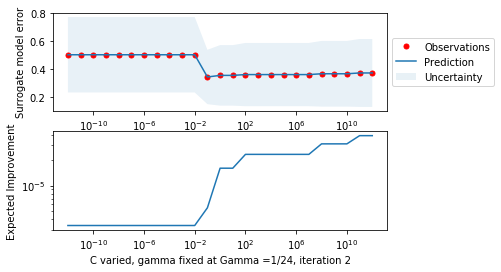

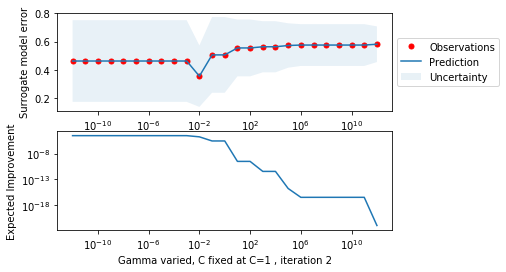

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


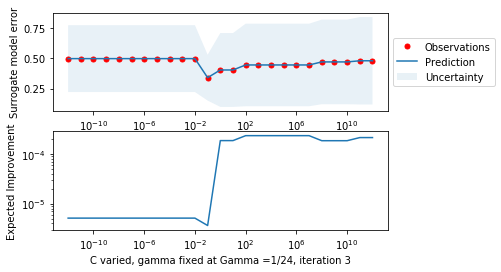

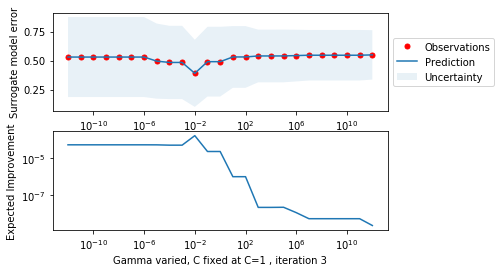

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


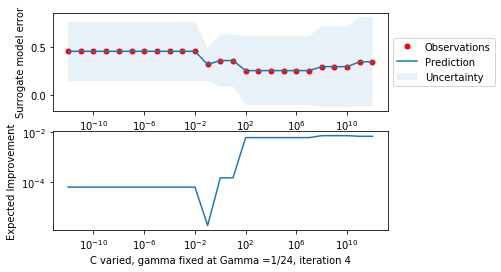

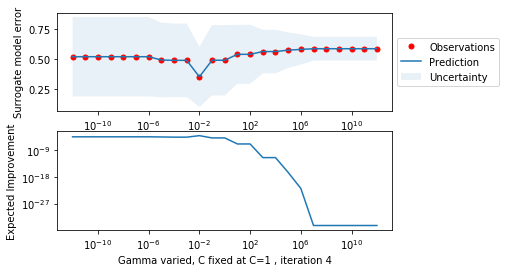

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [16]:
with open("ei_score_cvaried_gamma_fixed.pkl", "rb") as f:
    ei_score_cvaried_gamma_fixed = pickle.load(f)

with open("ei_score_gamma_varied_c_fixed", "rb") as f:
    ei_score_gamma_varied_c_fixed = pickle.load(f)


def q1_3it_callstack(random_param: np.array,                             #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    """First, we calculate the optimal hyperparameter setup 
    from the EI results in the previous question. 
    Then we repeat the procedure 3 times. This gives us a total of 4 iterations"""
    max_ei_param_1 = np.unravel_index(np.argmax(ei_score_cvaried_gamma_fixed, axis=None), shape=ei_score_cvaried_gamma_fixed.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei_score_gamma_varied_c_fixed,  axis=None), shape=ei_score_gamma_varied_c_fixed.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = c_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = gamma_points[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

#Generate results of second sub-question (Plots for three more iterations). Like in the previous question,
#We define two slices, one where C varies and gamma is fixed, and one where gamma is varied and C is fixed.
#We then save the resulting parameter list to disk for use in later questions. 
param_list_four_iterations = q1_3it_callstack(random_hyperparams, 'accuracy', c_points_gamma_fixed, gamma_points_c_fixed, 
                                              c_points, gamma_points, "C varied, gamma fixed at Gamma =1/24", 
                                              "Gamma varied, C fixed at C=1 ", classification=True)

with open("param_list_four_iterations.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations, f)

For the second iteration, we see that the surrogate model of C has the lowest error at 10^-1. A strange thing we see however,
Is that the expected improvement is guiding us towards larger C values. Expected imrpovement is highest at very large C values.
For Gamma, the error on the surrogate model is lowest 10^-2. Here the expected improvement is highest at very small values 
for gamma. 

For the third iteration, we see again that the surrogate model of C has the lowest error at 10^-1. However, the highest 
Expected improvement is at 10^11. This is a bit unexpected and strange, we would have expected it to be around 10^-1 again.
The surrogate model of Gamma we see that the error is lowest at 10-2, and maximum expected improvement is at the same point 
(10^-2). This is what we expected. 

For the fourth iteration, for C in the surrogate model we now really see that the error does seem to go do down if C 
is increased.This is interesting, because it seems that the Expected improvement did correctly guide us towards 
increasing the C parameter after all. We will see how this continues. For Gamma, Results are mostly similar: 
Again the error is lowest at 10^-2, and the maximum expected improvement also lies here (We can see a bump in the plot)

One point to take note of is the way we defined our c_points and gamma points. Since we take the random parameters and gamma
and c values from the following code:
c_points = np.logspace(-12,12, 25)                                      
gamma_points = np.logspace(-12, 12, 25)    
We did this because we think this is the correct way, but in this way we can not really "zoom in" on parameters, because we 
only allow the parameters to take on "integer" powers, so for example we don't let the parameters of C and Gamma
be 10^-1.5, or 10^-2.5. (Or any continuous value for that matter). Maybe if we did allow this, we could find more 
expected improvement. It was not really clear for us if we had to use continuous or discrete parameter values.
Please note that we chose for discrete values not out of ignorance, but because we thought this was the way to go. 
This also applies for subsequent questions. 

New parameters sucessfully set, length of list is now 15
Iteration 5 completed
New parameters sucessfully set, length of list is now 16
Iteration 6 completed
New parameters sucessfully set, length of list is now 17
Iteration 7 completed
New parameters sucessfully set, length of list is now 18
Iteration 8 completed
New parameters sucessfully set, length of list is now 19
Iteration 9 completed
New parameters sucessfully set, length of list is now 20
Iteration 10 completed
New parameters sucessfully set, length of list is now 21
Iteration 11 completed
New parameters sucessfully set, length of list is now 22
Iteration 12 completed
New parameters sucessfully set, length of list is now 23
Iteration 13 completed
New parameters sucessfully set, length of list is now 24
Iteration 14 completed
New parameters sucessfully set, length of list is now 25
Iteration 15 completed
New parameters sucessfully set, length of list is now 26
Iteration 16 completed
New parameters sucessfully set, length of lis

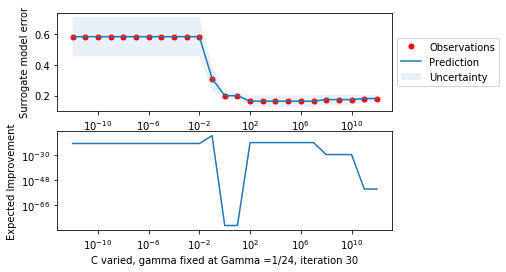

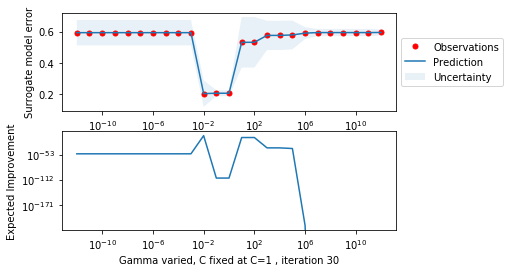

In [18]:
#Open results from previous question
with open("param_list_four_iterations.pkl", "rb") as f:
    param_list_four_iterations_loaded = pickle.load(f)

def q1_30it_callstack(scoring_metric: str,
                     fixed_slice_1: np.array, fixed_slice_2: np.array,
                     param_x_axis_1: np.array, param_x_axis_2: np.array,
                     x_axis_text1: str, x_axis_text2: str,
                     classification = True):
    new_param_list = param_list_four_iterations_loaded
    y1, sig1, rf1, =(0,0,0)
    y2, sig2, rf2, = (0,0,0)
    ei_score1, ei_score2 = (0,0)
    for i in range(26):
        score = surrogate_model_fitter(new_param_list, scoring_metric)
        rf_score = calculate_rf_input(score, classification)

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = c_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = gamma_points[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list)))
        print("Iteration {} completed".format(i+5)) #Since we've already done 4 iterations and i starts @ zero
    surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration 30'.format(x_axis_text1))
    surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration 30'.format(x_axis_text2))
    return new_param_list

#Generate results of third sub-question (30 iterations), with the same parameter slices as before.
final_param_list = q1_30it_callstack('accuracy', c_points_gamma_fixed, gamma_points_c_fixed, c_points, gamma_points,
                 "C varied, gamma fixed at Gamma =1/24", "Gamma varied, C fixed at C=1 ", classification=True)

#save the results to disk for use in later questions
with open('final_param_list.pkl', 'wb') as f:
    pickle.dump(final_param_list, f)